# ARIMA Modelling in R (but now Python)

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
#Importing raw data
elecequip = pd.read_csv("Data/elecequip.csv")
#Adding time index
elec_index = pd.date_range(start = '1996-01-01', end = '2012-04-01', freq='M').to_pydatetime()
elecequip.index = elec_index
elecequip

,x
1996-01-31,79.35
1996-02-29,75.78
1996-03-31,86.32
1996-04-30,72.60
1996-05-31,74.86
...,...
2011-11-30,93.37
2011-12-31,98.34
2012-01-31,86.44
2012-02-29,85.04


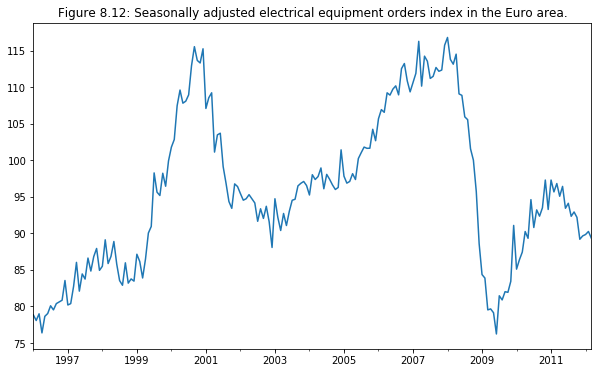

In [3]:
#Seasonal adjustment using STL
from statsmodels.tsa.seasonal import STL
elecequip_stl = STL(elecequip, period=12).fit()
#Subtracting seasonal component
elecequip_adj = pd.DataFrame({'x':elecequip.values[:,0] - elecequip_stl.seasonal.values}, index = elecequip.index)
elecequip_adj.plot.line(title ='Figure 8.12: Seasonally adjusted electrical equipment orders index in the Euro area.', figsize=(10,6), legend=False)


Note that the STL decomposition gives slightly different results than the one inbuilt into R. So the following results will be different as well.

Plotting the first difference

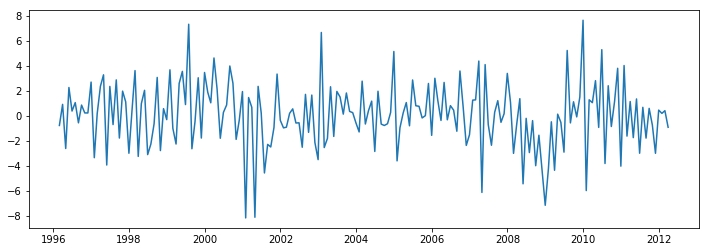

In [4]:
fig, ax = plt.subplots(figsize=(12,4))
eeadj_diff = elecequip_adj.diff()
ax.plot(elecequip_adj.index, elecequip_adj.diff().values)

Plotting the diff with acf and pacf. 
Note that Python does not have an exact analogue as far as I'm aware so the code is quite a bit longer than the one liner in FPP.

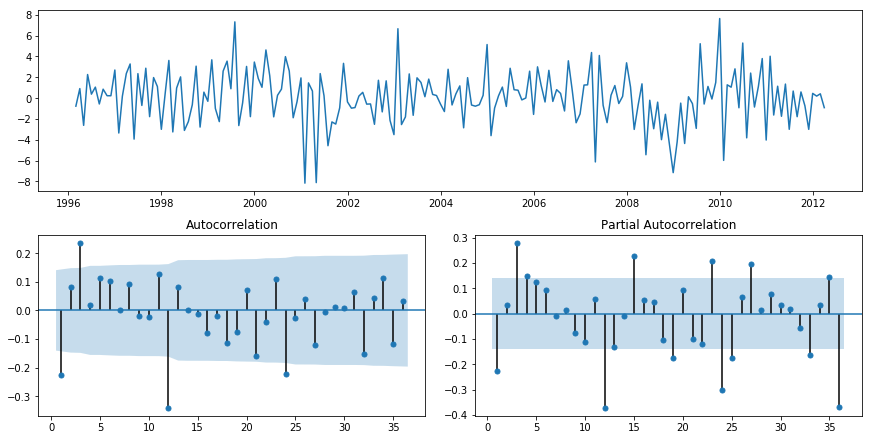

In [5]:
import matplotlib.gridspec as gridspec

fig3 = plt.figure(constrained_layout=True, figsize=(12,6))
gs = fig3.add_gridspec(2, 2)

#Differenced series
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.plot(elecequip_adj.index, eeadj_diff.values)

#Acf
f3_ax2 = fig3.add_subplot(gs[1,0])
acf = statsmodels.graphics.tsaplots.plot_acf(eeadj_diff[1:], ax=f3_ax2, lags=36, zero=False)

#Pacf
f3_ax3 = fig3.add_subplot(gs[1,1])
pacf = statsmodels.graphics.tsaplots.plot_pacf(eeadj_diff[1:], ax=f3_ax3, lags=36, zero=False)

The seasonality doesn't seem to be accounted for, we can still see significant PACF lags at 12, 24 and 36. Perhaps I'm implementing STL wrongly here.

# Fitting an ARIMA model

- Fitting ARIMA(3,1,0) along with variations (4,1,0), (2,1,0) and (3,1,1) 

In [6]:
orders = [(3,1,0), (4,1,0), (2,1,0), (3,1,1)]

for pqd in orders:
    arima_temp = statsmodels.tsa.arima.model.ARIMA(elecequip_adj, dates=elecequip_adj.index, order=pqd, freq='M')
    arima_temp_results = arima_temp.fit()
    print(pqd , 'AIC:', arima_temp_results.aic)

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


(3, 1, 0) AIC: 904.1748030586295
(4, 1, 0) AIC: 902.1467335388884
(2, 1, 0) AIC: 917.343508718647


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


(3, 1, 1) AIC: 899.0877699927275


(3,1,1) has the lowest AIC which is consistent with the results in FPP.

Not sure why I'm getting warnings when I've specified the frequency...

Note that to get the forecast intervals, I have to use the deprecated form of the ARIMA model statsmodels.tsa.arima_model.ARIMA as opposed to the more up to date version statsmodels.tsa.arima.model.ARIMA

In [7]:
arima_model = statsmodels.tsa.arima_model.ARIMA(elecequip_adj, order=(3,1,1), freq='M')
arima_results = arima_model.fit()
arima_results.summary()

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.x   No. Observations:                  194
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -444.530
Method:                       css-mle   S.D. of innovations              2.390
Date:                Thu, 02 Jul 2020   AIC                            901.061
Time:                        16:17:58   BIC                            920.668
Sample:                    02-29-1996   HQIC                           909.000
                         - 03-31-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0452      0.275      0.164      0.869      -0.494       0.585
ar.L1.D.x      0.2596      0.127      2.039      0.041       0.010       0.509
ar.L2.D.x      0.1984      0.072      2.749      0.006       0.057       0.340
ar.L3.D.x      0.2638      0.073      3.599      0.000       0.120       0.407
ma.L1.D.x     -0.5447      0.119     -4.562      0.000      -0.779      -0.311
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1712           -0.0000j            1.1712           -0.0000
AR.2           -0.9617           -1.5205j            1.7991           -0.3398
AR.3           -0.9617           +1.5205j            1.7991            0.3398
MA.1            1.8358           +0.0000j            1.8358            0.0000
-----------------------------------------------------------------------------
"""

# Residual Analysis

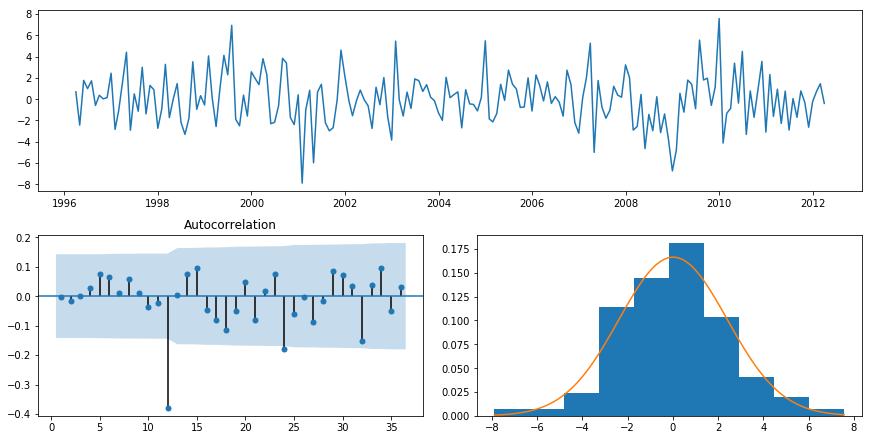

In [8]:
resids = arima_results.resid[1:]
mu, sigma = stats.norm.fit(resids)
lb = min(resids)
ub = max(resids)
domain = np.linspace(lb, ub, 100)
pdf = stats.norm.pdf(domain, loc=mu, scale=sigma)


fig_resids = plt.figure(constrained_layout=True, figsize=(12,6))
gs = fig_resids.add_gridspec(2, 2)

#Differenced series
fig_resids_ax1 = fig_resids.add_subplot(gs[0, :])
fig_resids_ax1.plot(resids.index, resids.values)

#Acf
fig_resids_ax2 = fig_resids.add_subplot(gs[1,0])
acf = statsmodels.graphics.tsaplots.plot_acf(resids[3:], ax=fig_resids_ax2, lags=36, zero=False)

#Histogram
fig_resids_ax3 = fig_resids.add_subplot(gs[1,1])
plt.hist(resids, density=True)
plt.plot(domain, pdf)

##Alternatively if you want to use counts on the histogram. Note that the scaling is arbitrary, you can change it using the number of bins.
#fig_resids_ax3 = fig_resids.add_subplot(gs[1,1])
#plt.hist(resids, 16)
#plt.plot(domain, pdf*len(resids)) 

As mentioned above, there is still very strong seasonality in the residuals. Note that I've elected to use a density/probability in the y-axis for the histogram as the scaling of the pdf to the raw counts is somewhat arbitrary. 

# Forecasting 

Note that we have to use the deprecated for the ARIMA model to get interval forecasts.

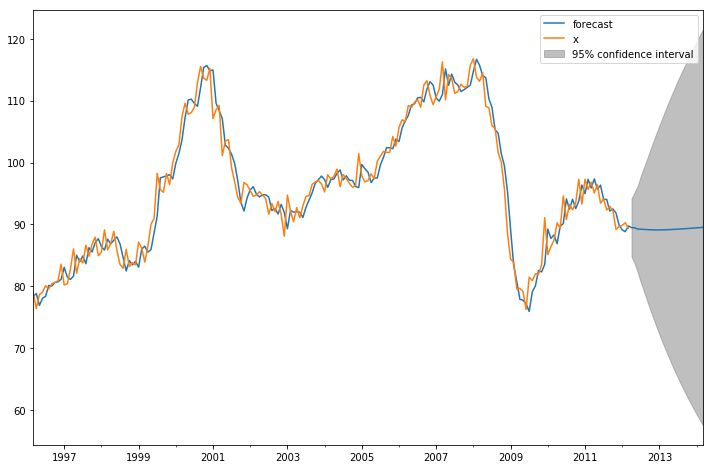

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
arima_model = statsmodels.tsa.arima_model.ARIMA(elecequip_adj, order=(3,1,1), freq='M')
arima_results = arima_model.fit()
arima_results.summary()
plot = arima_results.plot_predict(start=2, end=218, ax=ax)

Text(0.5, 1.0, 'Inverse MA roots')

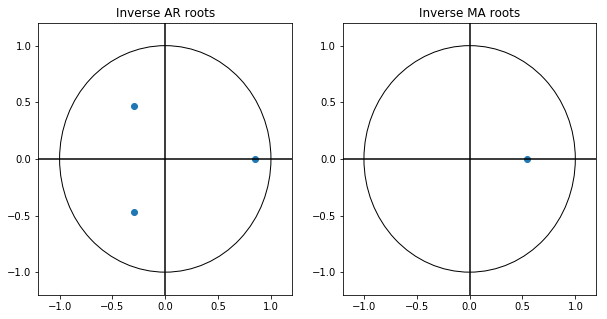

In [10]:
inverse_ar = 1/arima_results.arroots
inverse_ma = 1/arima_results.maroots

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.set_xlim((-1.2,1.2))
ax1.set_ylim((-1.2,1.2))
ax2.set_xlim((-1.2,1.2))
ax2.set_ylim((-1.2,1.2))

unit1 = plt.Circle((0,0), radius=1, edgecolor='black', facecolor='None')
unit2 = plt.Circle((0,0), radius=1, edgecolor='black', facecolor='None')

ax1.scatter(inverse_ar.real, inverse_ar.imag)
ax1.axhline(y=0, color='black')
ax1.axvline(x=0, color='black')
ax1.add_patch(unit1)
ax1.set_title("Inverse AR roots")

ax2.scatter(inverse_ma.real, inverse_ma.imag)
ax2.axhline(y=0, color='black')
ax2.axvline(x=0, color='black')
ax2.add_patch(unit2)
ax2.set_title("Inverse MA roots")

A lot more work to code up unfortunately. Perhaps this should be built into the statsmodel package? 